In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import mplhep
import uproot

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
tf.data.experimental.enable_debug_mode()

On this case, this was the AE used for the first approach. The way of working is rather similar to the DeltaRij matrix one, with some slightly modifications which will be comented now.

1) The acquisition of data is the same as DeltaRij matrix both for SM and SUEPs

In [2]:
my_file = uproot.open('MinBias.root')
tree = my_file['TupleTest/TupleTest']
data_df = tree.arrays(library='pd')
my_file.close()  # usually, it's better to open the file with a "with" statement -> needs no closing

# Show the first 5 lines of the DataFrame
data_df.head()

Px          Py            Pz          Pt             E       Eta  \
0  -82.360001   46.580002  14412.629883   94.619583  14412.940430  5.719154   
1  -19.600000   53.840000  40730.078125   57.296646  40730.121094  7.259628   
2  -69.949997 -161.399994  68758.343750  175.906113  68758.703125  6.661551   
3  422.029999 -423.790009   7772.229980  598.086365   7810.824707  3.259202   
4  -89.269997   50.880001    624.719971  102.751678    648.315491  2.504831   

        Phi     ID     PVx     PVy      PVz         OVx      OVy  \
0  2.626877   22.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
1  1.919925   22.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
2 -1.979756  211.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
3 -0.787479  321.0 -0.0239  0.0114  80.8918 -101.334999 -24.0208   
4  2.623557 -211.0 -0.0239  0.0114  80.8918 -101.334999 -24.0208   

            OVz   flight_dx  flight_dy     flight_dz  evtNumber  pvID    nPVs  
0     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
1     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
2     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
3  10298.225586  101.311096    24.0322  10217.333984        1.0   0.0  5512.0  
4  10298.225586  101.311096    24.0322  10217.333984        1.0   0.0  5512.0

In [3]:
Pt=data_df['Pt'].to_numpy()
Eta=data_df['Eta'].to_numpy()
Phi=data_df['Phi'].to_numpy()
NEvent=data_df['evtNumber'].to_numpy()
E=data_df['E'].to_numpy()
Pz=data_df['Pz'].to_numpy()
PVI=data_df['pvID'].to_numpy()
fly=data_df['flight_dz'].to_numpy()
Px=data_df['Px'].to_numpy()
Py=data_df['Py'].to_numpy()


Etadef=[]
Ptdef=[]
Phidef=[]
Neventdef=[]
Edef=[]
flydef=[]
PVIdef=[]
Pzdef=[]
Pxdef=[]
Pydef=[]



for i in range(len(Eta)):
    if (Eta[i] >2.0 and Eta[i]<4.5) or (Eta[i]<-2.0 and Eta[i]>-4.5):
        if Pt[i]>250.0 and Pt[i] <75000. and fly[i] < 1:
            Etadef.append(Eta[i])
            Ptdef.append(Pt[i])
            Phidef.append(Phi[i])
            Neventdef.append(NEvent[i])
            Edef.append(E[i])
            flydef.append(fly[i])
            PVIdef.append(PVI[i])
            Pzdef.append(Pz[i])
            Pxdef.append(Px[i])
            Pydef.append(Py[i])
        
        
Ptdef=np.array(Ptdef)
Etadef=np.array(Etadef)
Phidef=np.array(Phidef)
#Phidef=Phidef+np.pi
Pxdef=np.array(Pxdef)
Pydef=np.array(Pydef)
Pzdef=np.array(Pzdef)
Edef=np.array(Edef)

Ptdef=Ptdef/1000. #GeV
Pxdef=Pxdef/1000. #GeV
Pydef=Pydef/1000. #GeV
Pzdef=Pzdef/1000. #GeV
Edef=Edef/1000. #GeV





Now we are commenting the main differences on the training test set:

1)  We are working with 7 variables instead of two. We have therefore to define a variable c which includes thw number of physical parameters we are working with.

2) Therefore, a matrix of cxb elements was created, where all the tracks associated with the physical parameter go on each row.

In [5]:
from sklearn.preprocessing import MinMaxScaler
scPt=MinMaxScaler(feature_range=(0,1))
scEta=MinMaxScaler(feature_range=(0,1))
scPhi=MinMaxScaler(feature_range=(0,1))
scE=MinMaxScaler(feature_range=(0,1))
scPz=MinMaxScaler(feature_range=(0,1))
scPx=MinMaxScaler(feature_range=(0,1))
scPy=MinMaxScaler(feature_range=(0,1))



b=24  #tracks per event
c=7 #Variables 
input_train=[]
input_test=[]
cuentatrain=0
cuentatest=0
totPt=[]
totEta=[]
totPhi=[]
totE=[]
totPz=[]
pttest=[]
Etatest=[]
Phitest=[]
Etest=[]
Pztest=[]
a=0
for i in range(len(PVIdef)-1): #I check the nEvents list and when I pass from one event to the following I keep the data
    if int(PVIdef[i+1])==int(PVIdef[i]):
        a+=1
    else:
        if a>=b: #If the number of tracks is bigger than cutoof I take the event
    
            Rij=np.ones([c,b])
            pteventos=np.array(Ptdef[i-a:i+1]) #I take the data of the event
            Etaeventos=np.array(Etadef[i-a:i+1])
            Phieventos=np.array(Phidef[i-a:i+1])
            Eeventos=np.array(Edef[i-a:i+1])
            Pzeventos=np.array(Pzdef[i-a:i+1])
            Pxeventos=np.array(Pxdef[i-a:i+1])
            Pyeventos=np.array(Pydef[i-a:i+1])

            
            ptML=[]
            EtaML=[]
            PhiML=[]
            EML=[]
            PzML=[]
            PxML=[]
            PyML=[]

            
            for j in range(b): #Now we are going to the take the highest pt tracks
                ptML.append(max(pteventos));indice=np.argmax(pteventos) #I take the maximun and its argument
                EtaML.append(Etaeventos[indice])
                PhiML.append(Phieventos[indice])
                EML.append(Eeventos[indice])
                PzML.append(Pzeventos[indice])
                PxML.append(Pxeventos[indice])
                PyML.append(Pyeventos[indice])

                pteventos=np.delete(pteventos,indice) #I delete the maximum and do it again
                Etaeventos=np.delete(Etaeventos,indice)
                Phieventos=np.delete(Phieventos,indice)
                Eeventos=np.delete(Eeventos,indice)
                Pzeventos=np.delete(Pzeventos,indice)
                Pxeventos=np.delete(Pxeventos,indice)
                Pyeventos=np.delete(Pyeventos,indice)

                
            
            
        
        
            ptML=np.array(ptML).reshape(-1,1);ptML=scPt.fit_transform(ptML) #I take all the elements as [],[],[] and then do the
            EtaML=np.array(EtaML).reshape(-1,1);EtaML=scEta.fit_transform(EtaML) #normalisation
            PhiML=np.array(PhiML).reshape(-1,1);PhiML=scPhi.fit_transform(PhiML)
            EML=np.array(EML).reshape(-1,1);EML=scE.fit_transform(EML)
            PzML=np.array(PzML).reshape(-1,1);PzML=scPz.fit_transform(PzML)
            PxML=np.array(PxML).reshape(-1,1);PxML=scPx.fit_transform(PxML)
            PyML=np.array(PyML).reshape(-1,1);PyML=scPy.fit_transform(PyML)




        
        
            
            
            
            for k in range(b): #I associate the matrix all the normalised data
                Rij[0,k]=ptML[k][0]
                Rij[1,k]=EtaML[k][0]
                Rij[2,k]=PhiML[k][0]
                Rij[3,k]=EML[k][0]
                Rij[4,k]=PzML[k][0]
                Rij[5,k]=PxML[k][0]
                Rij[6,k]=PyML[k][0]
                
            #Rij=(Rij - Rij.min()) / (Rij.max() - Rij.min())
                
            if cuentatrain >= 12200: #This is the number of train events I am choosing
                for l in range(b):
                    pttest.append(ptML[l][0])
                    Etatest.append(EtaML[l][0])
                    Phitest.append(PhiML[l][0])
                    Etest.append(EML[l][0])
                    Pztest.append(PzML[l][0])
                input_test.append(Rij)   
                cuentatest+=1
                a=0
            else:
                for l in range(b):
                    totPt.append(ptML[l][0])
                    totEta.append(EtaML[l][0])
                    totPhi.append(PhiML[l][0])
                    totE.append(EML[l][0])
                    totPz.append(PzML[l][0])
                input_train.append(Rij)
                cuentatrain+=1
                a=0
        else:
            a=0
            
deftrain=np.ones([cuentatrain,c,b]) #I define the tensor which will keep the data for the train
deftest=np.ones([cuentatest,c,b]) #Same for test
for i in range(cuentatrain):
    for j in range(c):
        for k in range(b):
            deftrain[i,j,k]=input_train[i][j,k]

for i in range(cuentatest):
    for j in range(c):
        for k in range(b):
            deftest[i,j,k]=input_test[i][j,k]
            
            

We follow the same procedure with the SUEP one

In [7]:
#Now we follow the same strategy with SUEPs
from sklearn.preprocessing import MinMaxScaler
scPtSUEP=MinMaxScaler(feature_range=(0,1))
scEtaSUEP=MinMaxScaler(feature_range=(0,1))
scPhiSUEP=MinMaxScaler(feature_range=(0,1))
scESUEP=MinMaxScaler(feature_range=(0,1))
scPzSUEP=MinMaxScaler(feature_range=(0,1))
scPxSUEP=MinMaxScaler(feature_range=(0,1))
scPySUEP=MinMaxScaler(feature_range=(0,1))
dataSUEP=pd.read_csv("SUEP_Simulation_10k_Andrii.csv")
dfSUEP=pd.DataFrame(dataSUEP)
nTracksSUEP=dfSUEP['nTracks'].to_numpy()
nEventsSUEP=dfSUEP['Nevents'].to_numpy()
ptSUEP=dfSUEP["trackPt"].to_numpy()
etaSUEP=dfSUEP["trackEta"].to_numpy()
phiSUEP=dfSUEP["trackPhi"].to_numpy()
#phiSUEP= phiSUEP + np.pi
ESUEP=dfSUEP['trackE'].to_numpy()
PzSUEP=dfSUEP['trackPz'].to_numpy()
PxSUEP=dfSUEP['trackPx'].to_numpy()
PySUEP=dfSUEP['trackPy'].to_numpy()

b=24 #tracks per event
c=7 #variables we are working with
input_trainSUEP=[]
input_testSUEP=[]
cuentatrainSUEP=0
cuentatestSUEP=0
totPtSUEP=[]
totEtaSUEP=[]
totPhiSUEP=[] 
totESUEP=[] 
totPzSUEP=[] 
pttestSUEP=[]
EtatestSUEP=[]
PhitestSUEP=[]
EtestSUEP=[]
PztestSUEP=[]

for i in range(len(nEventsSUEP)-1):
    d=int(nEventsSUEP[i])
    if int(nEventsSUEP[i+1])!=d:
        a=int(nTracksSUEP[i])
        if a>=b:
            pteventosSUEP=[]
            EtaeventosSUEP=[]
            PhieventosSUEP=[]
            EeventosSUEP=[]
            PzeventosSUEP=[]
            PxeventosSUEP=[]
            PyeventosSUEP=[]


    
            RijSUEP=np.ones([c,b])
            pteventosSUEP=np.array(ptSUEP[i-a+1:i+2])
            EtaeventosSUEP=np.array(etaSUEP[i-a+1:i+2])
            PhieventosSUEP=np.array(phiSUEP[i-a+1:i+2])
            EeventosSUEP=np.array(ESUEP[i-a+1:i+2])
            PzeventosSUEP=np.array(PzSUEP[i-a+1:i+2])
            PxeventosSUEP=np.array(PxSUEP[i-a+1:i+2])
            PyeventosSUEP=np.array(PySUEP[i-a+1:i+2])

            
            ptMLSUEP=[]
            EtaMLSUEP=[]
            PhiMLSUEP=[]
            EMLSUEP=[]
            PzMLSUEP=[]
            PxMLSUEP=[]
            PyMLSUEP=[]

            
            for j in range(b):
                ptMLSUEP.append(max(pteventosSUEP));indice=np.argmax(pteventosSUEP)
                EtaMLSUEP.append(EtaeventosSUEP[indice])
                PhiMLSUEP.append(PhieventosSUEP[indice])
                EMLSUEP.append(EeventosSUEP[indice])
                PzMLSUEP.append(PzeventosSUEP[indice])
                PxMLSUEP.append(PxeventosSUEP[indice])
                PyMLSUEP.append(PyeventosSUEP[indice])

                
                pteventosSUEP=np.delete(pteventosSUEP,indice)
                EtaeventosSUEP=np.delete(EtaeventosSUEP,indice)
                PhieventosSUEP=np.delete(PhieventosSUEP,indice)
                EeventosSUEP=np.delete(EeventosSUEP,indice)
                PzeventosSUEP=np.delete(PzeventosSUEP,indice)
                PxeventosSUEP=np.delete(PxeventosSUEP,indice)
                PyeventosSUEP=np.delete(PyeventosSUEP,indice)

                
        
            ptMLSUEP=np.array(ptMLSUEP).reshape(-1,1)#;ptMLSUEP=scPtSUEP.fit_transform(ptMLSUEP)
            EtaMLSUEP=np.array(EtaMLSUEP).reshape(-1,1)#;EtaMLSUEP=scEtaSUEP.fit_transform(EtaMLSUEP)
            PhiMLSUEP=np.array(PhiMLSUEP).reshape(-1,1)#;PhiMLSUEP=scPhiSUEP.fit_transform(PhiMLSUEP)
            EMLSUEP=np.array(EMLSUEP).reshape(-1,1)#;EMLSUEP=scESUEP.fit_transform(EMLSUEP)
            PzMLSUEP=np.array(PzMLSUEP).reshape(-1,1)#;PzMLSUEP=scPzSUEP.fit_transform(PzMLSUEP)
            PxMLSUEP=np.array(PxMLSUEP).reshape(-1,1)#;PxMLSUEP=scPzSUEP.fit_transform(PxMLSUEP)
            PyMLSUEP=np.array(PyMLSUEP).reshape(-1,1)#;PyMLSUEP=scPzSUEP.fit_transform(PyMLSUEP)



        
        
            
            
            
            for k in range(b):
                RijSUEP[0,k]=ptMLSUEP[k][0]
                RijSUEP[1,k]=EtaMLSUEP[k][0]
                RijSUEP[2,k]=PhiMLSUEP[k][0]
                RijSUEP[3,k]=EMLSUEP[k][0]
                RijSUEP[4,k]=PzMLSUEP[k][0]
                RijSUEP[5,k]=PxMLSUEP[k][0]
                RijSUEP[6,k]=PyMLSUEP[k][0]

            #RijSUEP=(RijSUEP - RijSUEP.min()) / (RijSUEP.max() - RijSUEP.min())

                
            if cuentatrainSUEP >= 1802:
                for l in range(b):
                    pttestSUEP.append(ptMLSUEP[l][0])
                    EtatestSUEP.append(EtaMLSUEP[l][0])
                    PhitestSUEP.append(PhiMLSUEP[l][0])
                    EtestSUEP.append(EMLSUEP[l][0])
                    PztestSUEP.append(PzMLSUEP[l][0])

                input_testSUEP.append(RijSUEP)    
                cuentatestSUEP+=1
            else:
                for l in range(b):
                    totPtSUEP.append(ptMLSUEP[l][0])
                    totEtaSUEP.append(EtaMLSUEP[l][0])
                    totPhiSUEP.append(PhiMLSUEP[l][0])
                    totESUEP.append(EMLSUEP[l][0])
                    totPzSUEP.append(PzMLSUEP[l][0])
                input_trainSUEP.append(RijSUEP)
                cuentatrainSUEP+=1
                
deftrainSUEP=np.ones([cuentatrainSUEP,c,b])
deftestSUEP=np.ones([cuentatestSUEP,c,b])
for i in range(cuentatrainSUEP):
    for j in range(c):
        for k in range(b):
            deftrainSUEP[i,j,k]=input_trainSUEP[i][j,k]

for i in range(cuentatestSUEP):
    for j in range(c):
        for k in range(b):
            deftestSUEP[i,j,k]=input_testSUEP[i][j,k]
            
    

Some plots were done below to check the variables we are working with

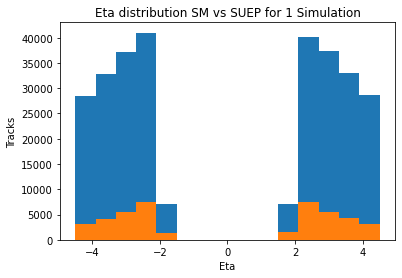

In [10]:
plt.hist(totEta,bins=15)
plt.hist(totEtaSUEP,bins=15)
plt.title('Eta distribution SM vs SUEP for 1 Simulation')
plt.xlabel('Eta')
plt.ylabel('Tracks')
plt.savefig('Eta_1Simulations.png',dpi=400)

Now two different AE model were built. The first one is one with Convolutional Layers, reducting the gigher dimnesionality of the matrix (strides = (1,2), reducting the number of columns. The second one is a Dense Layer one (which performed worse results). Tanh activation functions for the encoder and decoder were used, except the final one of the decoder which was a sigmoid one. I would use the first model.

In [11]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(7, 24, 1)),
      layers.Conv2D(16, (3, 3),strides=(1,2), activation='tanh', padding='same'),
      layers.Conv2D(32, (3, 3), strides=(1,2), activation='tanh', padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(32, kernel_size=3, strides=(1,2), activation='tanh', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=(1,2),activation='tanh', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(24, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Now I implement the Sigma Function.

In [12]:
#This cell of for building the loss function we are using as the anomaly score

def sigmaf(y_pred):
    sigma=1./(1.+2.7182818284590**(-y_pred))
    return sigma

def custom_loss_function(y_true, y_pred):
    global b, cousa, cousa2, error
    cousa=y_true
    cousa2=y_pred
    suma=abs((y_pred-(1./(1.+2.7182818284590**(-y_true))))**3)
    suma=sum(suma)
    error=suma/b
    return error

#losses.MeanSquaredError()

In [9]:
autoencoder.compile(optimizer='adam',run_eagerly=True, loss=losses.MeanSquaredError())


The AE is trained with a number of epochs whose reconstruction error is almost plane.

In [10]:
autoencoder.fit(deftrain, deftrain,
                epochs=10, batch_size=8,
                shuffle=True,
                validation_data=(deftest, deftest))

Epoch 1/10
1525/1525 [==============================] - 26s 17ms/step - loss: 128.2831 - val_loss: 119.9207
Epoch 2/10
1525/1525 [==============================] - 25s 17ms/step - loss: 127.8044 - val_loss: 119.8203
Epoch 3/10
1525/1525 [==============================] - 26s 17ms/step - loss: 127.7420 - val_loss: 119.7733
Epoch 4/10
1525/1525 [==============================] - 26s 17ms/step - loss: 127.6925 - val_loss: 119.7245
Epoch 5/10
1525/1525 [==============================] - 26s 17ms/step - loss: 127.6316 - val_loss: 119.6852
Epoch 6/10
1525/1525 [==============================] - 28s 18ms/step - loss: 127.5937 - val_loss: 119.6458
Epoch 7/10
1525/1525 [==============================] - 27s 18ms/step - loss: 127.5689 - val_loss: 119.6319
Epoch 8/10
1525/1525 [==============================] - 28s 18ms/step - loss: 127.5537 - val_loss: 119.6252
Epoch 9/10
1525/1525 [==============================] - 29s 19ms/step - loss: 127.5459 - val_loss: 119.6086
Epoch 10/10
1525/1525 [=====

Now it starts the reconstruction part.

57/57 [==============================] - 0s 6ms/step


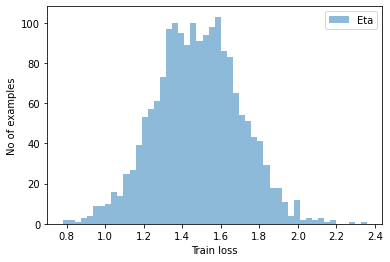

In [12]:
#Here we can see the reconstruction lost for some variables (the one from MSE)

reconstructionstest = autoencoder.predict(deftest)
test_loss = tf.keras.losses.mae(reconstructionstest[:,:,:,0], deftest) #If the dense layer were used, the line changes to
test_array= test_loss.numpy()                                          #test_loss = tf.keras.losses.mae(reconstructionstest, deftest)
plt.hist(test_array[:,2], bins=50,alpha=0.5,label='Eta')
plt.legend(loc='best')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [14]:
#Here i turn test and reconstruction data as array and do some comparison plots with the data

totaepttest=[] #AE reconstruction
totaeEtatest=[]
totaePhitest=[]
totaeEtest=[]
totaePztest=[]
totaePxtest=[]
totaePytest=[]



for i in range(cuentatest):
    for k in range(b):
        #totaepttest.append(float(reconstructionstest[i][0][k])) #These are for the dense layer AE
        #totaeEtatest.append(float(reconstructionstest[i][1][k]))
        #totaePhitest.append(float(reconstructionstest[i][2][k]))
        #totaeEtest.append(float(reconstructionstest[i][3][k]))
        #totaePztest.append(float(reconstructionstest[i][4][k]))
        #totaePxtest.append(float(reconstructionstest[i][5][k]))
        #totaePytest.append(float(reconstructionstest[i][6][k]))

        #totaepttest.append(float(reconstructionstest[i][0][k][0])) #these are for the Convolutional one
        #totaeEtatest.append(float(reconstructionstest[i][1][k][0]))
        #totaePhitest.append(float(reconstructionstest[i][2][k][0]))
        #totaeEtest.append(float(reconstructionstest[i][3][k][0]))
        #totaePztest.append(float(reconstructionstest[i][4][k][0]))
        #totaePxtest.append(float(reconstructionstest[i][5][k][0]))
        #totaePytest.append(float(reconstructionstest[i][6][k][0]))

        
totpttest=[] #Test data raw
totEtatest=[]
totPhitest=[]
totEtest=[]
totPztest=[]
totPxtest=[]
totPytest=[]



for i in range(cuentatest):
    for k in range(b):
        totpttest.append(float(deftest[i][0][k]))
        totEtatest.append(float(deftest[i][1][k]))
        totPhitest.append(float(deftest[i][2][k]))        
        totEtest.append(float(deftest[i][3][k]))        
        totPztest.append(float(deftest[i][4][k])) 
        totPxtest.append(float(deftest[i][5][k]))        
        totPytest.append(float(deftest[i][6][k]))        



Now we present the comparison plots for Test SM (The first one is applied when normalisation is done, whereas the second one when it is not done; just choose the one you want for the case it is being treated).

In [ ]:
# now let's make some comparison plots
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3,3,sharey=False,figsize=(16,16))

fig.suptitle('Test data comparison SM')


bins = np.linspace(0,1,10)
axs[0,0].hist(totpttest, bins, alpha=0.5, label='Data')
axs[0,0].hist(totaepttest, bins, alpha=0.5, label='AE')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("Tracks")
axs[0,0].set_xlabel("Pt")

bins = np.linspace(0.,1.,10)
axs[0,1].hist(totEtatest, bins, alpha=0.5, label='Data')
axs[0,1].hist(totaeEtatest, bins, alpha=0.5, label='AE')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("Tracks")
axs[0,1].set_xlabel("Eta")

bins = np.linspace(0,1,10)
axs[1,0].hist(totPhitest, bins, alpha=0.5, label='Data')
axs[1,0].hist(totaePhitest, bins, alpha=0.5, label='AE')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("Tracks")
axs[1,0].set_xlabel("Phi")

bins = np.linspace(0,1,10)
axs[1,1].hist(totEtest, bins, alpha=0.5, label='Data')
axs[1,1].hist(totaeEtest, bins, alpha=0.5, label='AE')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("Tracks")
axs[1,1].set_xlabel("E")

bins = np.linspace(0,1,10)
axs[1,2].hist(totPztest, bins, alpha=0.5, label='Data')
axs[1,2].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("Tracks")
axs[1,2].set_xlabel("Pz ")

bins = np.linspace(0,1,10)
axs[2,0].hist(totPztest, bins, alpha=0.5, label='Data')
axs[2,0].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[2,0].legend(loc='upper right')
axs[2,0].set_ylabel("Tracks")
axs[2,0].set_xlabel("Px ")

bins = np.linspace(0,1,10)
axs[2,1].hist(totPztest, bins, alpha=0.5, label='Data')
axs[2,1].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[2,1].legend(loc='upper right')
axs[2,1].set_ylabel("Tracks")
axs[2,1].set_xlabel("Py ")



plt.savefig('Comparison_Data_Test_AE_7Variables_BWFW_NoNorm_MSE.png',dpi=300)


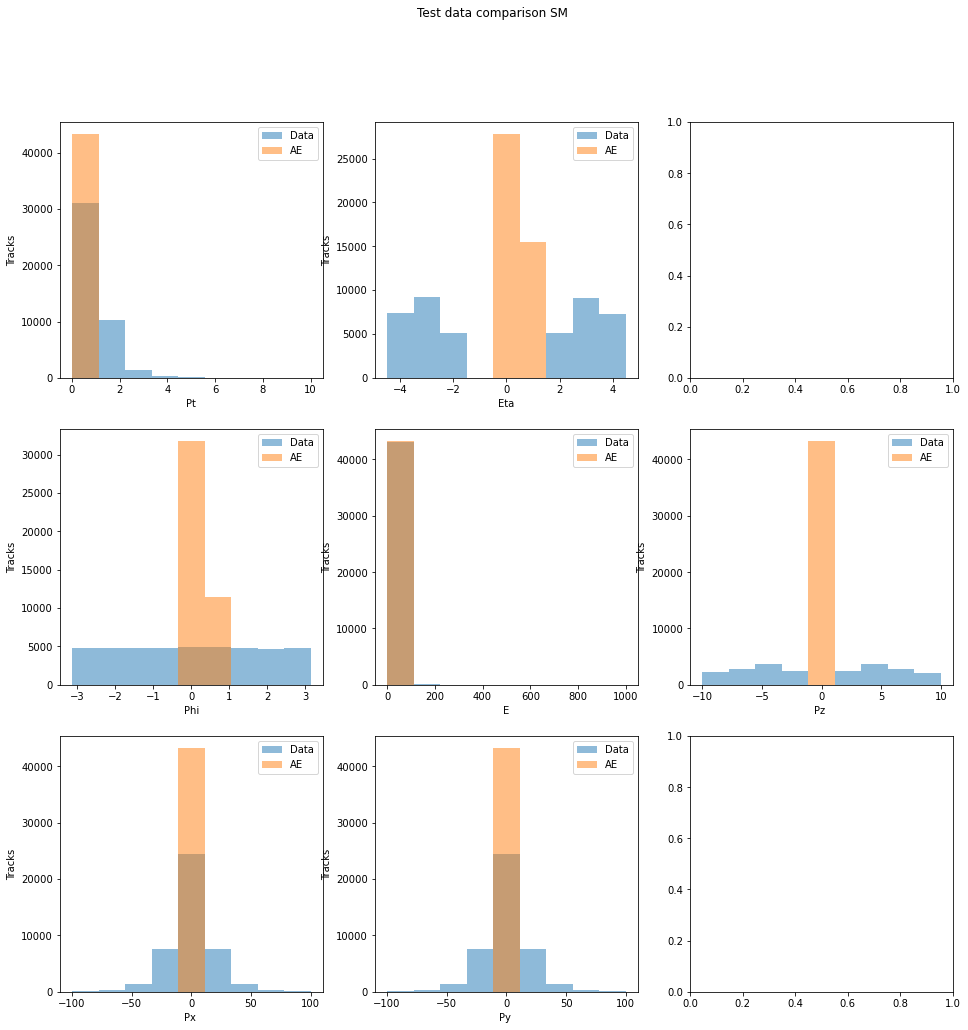

In [15]:
# now let's make some comparison plots
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3,3,sharey=False,figsize=(16,16))

fig.suptitle('Test data comparison SM')


bins = np.linspace(0,10,10)
axs[0,0].hist(totpttest, bins, alpha=0.5, label='Data')
axs[0,0].hist(totaepttest, bins, alpha=0.5, label='AE')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("Tracks")
axs[0,0].set_xlabel("Pt")

bins = np.linspace(-4.5,4.5,10)
axs[0,1].hist(totEtatest, bins, alpha=0.5, label='Data')
axs[0,1].hist(totaeEtatest, bins, alpha=0.5, label='AE')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("Tracks")
axs[0,1].set_xlabel("Eta")

bins = np.linspace(-np.pi,np.pi,10)
axs[1,0].hist(totPhitest, bins, alpha=0.5, label='Data')
axs[1,0].hist(totaePhitest, bins, alpha=0.5, label='AE')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("Tracks")
axs[1,0].set_xlabel("Phi")

bins = np.linspace(0,1000,10)
axs[1,1].hist(totEtest, bins, alpha=0.5, label='Data')
axs[1,1].hist(totaeEtest, bins, alpha=0.5, label='AE')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("Tracks")
axs[1,1].set_xlabel("E")

bins = np.linspace(-10,10,10)
axs[1,2].hist(totPztest, bins, alpha=0.5, label='Data')
axs[1,2].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("Tracks")
axs[1,2].set_xlabel("Pz ")

bins = np.linspace(-100,100,10)
axs[2,0].hist(totPztest, bins, alpha=0.5, label='Data')
axs[2,0].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[2,0].legend(loc='upper right')
axs[2,0].set_ylabel("Tracks")
axs[2,0].set_xlabel("Px ")

bins = np.linspace(-100,100,10)
axs[2,1].hist(totPztest, bins, alpha=0.5, label='Data')
axs[2,1].hist(totaePztest, bins, alpha=0.5, label='AE')
axs[2,1].legend(loc='upper right')
axs[2,1].set_ylabel("Tracks")
axs[2,1].set_xlabel("Py ")



plt.savefig('Comparison_Data_Test_AE_7Variables_BWFW_NoNorm_MSE.png',dpi=300)

Now we do the same for SUEPs, obtaining the reconstruction error. 

In [ ]:
reconstructions_SUEP = autoencoder.predict(deftrainSUEP)
train_loss_SUEP = tf.keras.losses.mae(reconstructions_SUEP[:,:,:,0], deftrainSUEP)
train_SUEP_array= train_loss_SUEP.numpy()
#plt.hist(train_SUEP_array[:,1], bins=10,alpha=0.5,label='Eta')
plt.hist(train_SUEP_array[:,2], bins=10,alpha=0.5,label='Phi')
plt.legend(loc='best')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.savefig
plt.show()

In [ ]:
#Same for SUEPs
totaepttestS=[]
totaeEtatestS=[]
totaePhitestS=[]
totaeEtestS=[]
totaePztestS=[]
totaePxtestS=[]
totaePytestS=[]



for i in range(cuentatrainSUEP):
    for k in range(b):
        totaepttestS.append(float(reconstructions_SUEP[i][0][k][0]))
        totaeEtatestS.append(float(reconstructions_SUEP[i][1][k][0]))
        totaePhitestS.append(float(reconstructions_SUEP[i][2][k][0]))
        totaeEtestS.append(float(reconstructions_SUEP[i][3][k][0]))
        totaePztestS.append(float(reconstructions_SUEP[i][4][k][0]))
        totaePxtestS.append(float(reconstructions_SUEP[i][5][k][0]))
        totaePytestS.append(float(reconstructions_SUEP[i][6][k][0]))

        
totpttestS=[]
totEtatestS=[]
totPhitestS=[]
totEtestS=[]
totPztestS=[]
totPxtestS=[]
totPytestS=[]



for i in range(cuentatrainSUEP):
    for k in range(b):
        totpttestS.append(float(deftrainSUEP[i][0][k]))
        totEtatestS.append(float(deftrainSUEP[i][1][k]))
        totPhitestS.append(float(deftrainSUEP[i][2][k]))        
        totEtestS.append(float(deftrainSUEP[i][3][k]))        
        totPztestS.append(float(deftrainSUEP[i][4][k]))   
        totPxtestS.append(float(deftrainSUEP[i][5][k]))        
        totPytestS.append(float(deftrainSUEP[i][6][k]))        



In [ ]:
# now let's make some comparison plots
import matplotlib.pyplot as plt
import numpy as np

del fig 
fig, axs = plt.subplots(3,3,sharey=False,figsize=(16,16))

fig.suptitle('Comparison SUEP')


bins = np.linspace(0,1,10)
axs[0,0].hist(totpttestS, bins, alpha=0.5, label='Data')
axs[0,0].hist(totaepttestS, bins, alpha=0.5, label='AE')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("events")
axs[0,0].set_xlabel("Pt")

bins = np.linspace(0,1,10)
axs[0,1].hist(totEtatestS, bins, alpha=0.5, label='Data')
axs[0,1].hist(totaeEtatestS, bins, alpha=0.5, label='AE')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("events")
axs[0,1].set_xlabel("Eta")

bins = np.linspace(0,1,10)
axs[1,0].hist(totPhitestS, bins, alpha=0.5, label='Data')
axs[1,0].hist(totaePhitestS, bins, alpha=0.5, label='AE')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("events")
axs[1,0].set_xlabel("Phi")

bins = np.linspace(0,1,10)
axs[1,1].hist(totEtestS, bins, alpha=0.5, label='Data')
axs[1,1].hist(totaeEtestS, bins, alpha=0.5, label='AE')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("events")
axs[1,1].set_xlabel("E")

bins = np.linspace(0,1,10)
axs[1,2].hist(totPztestS, bins, alpha=0.5, label='Data')
axs[1,2].hist(totaePztestS, bins, alpha=0.5, label='AE')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("events")
axs[1,2].set_xlabel("Pz")

bins = np.linspace(0,1,10)
axs[2,0].hist(totPxtestS, bins, alpha=0.5, label='Data')
axs[2,0].hist(totaePxtestS, bins, alpha=0.5, label='AE')
axs[2,0].legend(loc='upper right')
axs[2,0].set_ylabel("events")
axs[2,0].set_xlabel("Px")

bins = np.linspace(0,1,10)
axs[2,1].hist(totPytestS, bins, alpha=0.5, label='Data')
axs[2,1].hist(totaePytestS, bins, alpha=0.5, label='AE')
axs[2,1].legend(loc='upper right')
axs[2,1].set_ylabel("events")
axs[2,1].set_xlabel("Py")



plt.savefig('Comparison_SUEP_Test_AE4_7Variables_BWFW_NoNorm_MSE.png',dpi=300)

In [ ]:
# now let's make some comparison plots
import matplotlib.pyplot as plt
import numpy as np

del fig 
fig, axs = plt.subplots(3,3,sharey=False,figsize=(16,16))

fig.suptitle('Comparison SUEP')


bins = np.linspace(0,10,10)
axs[0,0].hist(totpttestS, bins, alpha=0.5, label='Data')
axs[0,0].hist(totaepttestS, bins, alpha=0.5, label='AE')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("events")
axs[0,0].set_xlabel("Pt")

bins = np.linspace(-4.5,4.5,10)
axs[0,1].hist(totEtatestS, bins, alpha=0.5, label='Data')
axs[0,1].hist(totaeEtatestS, bins, alpha=0.5, label='AE')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("events")
axs[0,1].set_xlabel("Eta")

bins = np.linspace(-np.pi,np.pi,10)
axs[1,0].hist(totPhitestS, bins, alpha=0.5, label='Data')
axs[1,0].hist(totaePhitestS, bins, alpha=0.5, label='AE')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("events")
axs[1,0].set_xlabel("Phi")

bins = np.linspace(0,10,10)
axs[1,1].hist(totEtestS, bins, alpha=0.5, label='Data')
axs[1,1].hist(totaeEtestS, bins, alpha=0.5, label='AE')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("events")
axs[1,1].set_xlabel("E")

bins = np.linspace(-10,10,10)
axs[1,2].hist(totPztestS, bins, alpha=0.5, label='Data')
axs[1,2].hist(totaePztestS, bins, alpha=0.5, label='AE')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("events")
axs[1,2].set_xlabel("Pz")

bins = np.linspace(-10,10,10)
axs[2,0].hist(totPxtestS, bins, alpha=0.5, label='Data')
axs[2,0].hist(totaePxtestS, bins, alpha=0.5, label='AE')
axs[2,0].legend(loc='upper right')
axs[2,0].set_ylabel("events")
axs[2,0].set_xlabel("Px")

bins = np.linspace(-10,10,10)
axs[2,1].hist(totPytestS, bins, alpha=0.5, label='Data')
axs[2,1].hist(totaePytestS, bins, alpha=0.5, label='AE')
axs[2,1].legend(loc='upper right')
axs[2,1].set_ylabel("events")
axs[2,1].set_xlabel("Py")



plt.savefig('Comparison_SUEP_Test_AE4_7Variables_BWFW_NoNorm_MSE.png',dpi=300)

Final step is to build the anomaly scores for both SM and SUEPs. 3 Anomaly Scores were applied: Sigma Function, MSE and EtaPhi. The procedures were the same as with the DeltaRij Matrix.

In [ ]:
#No we apply the reconstruction lost from SUEP paper 

def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructionstest[i,j,k,0]-sigma(deftest[i,j,k]))**3
            suma+=numerador
    error=suma/b
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructions_SUEP[i,j,k,0]-sigma(deftrainSUEP[i,j,k]))**3
            suma+=numerador
    errorSUEP=suma/b
    erroreventSUEP.append(errorSUEP)

plt.hist(errorevent, bins=2,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=100,alpha=0.5,label='error SUEP')
plt.title('SM and SUEP Simulation Lost')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('Loss_SM_SUEP_AE7_7Variables_MSE_BWFW_NoNorm.png', dpi=400)


In [ ]:
reconstructionstest[0,:,:,0]

In [ ]:
#No we apply the reconstruction lost from SUEP paper 

def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructionstest[i,j,k,0]-deftest[i,j,k])**2
            suma+=numerador
    error=suma/b
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP):
    suma=0
    for j in range(c):
        for k in range(b):
            numerador=np.abs(reconstructions_SUEP[i,j,k,0]-deftrainSUEP[i,j,k])**2
            suma+=numerador
    errorSUEP=suma/b
    erroreventSUEP.append(errorSUEP)

plt.hist(errorevent, bins=50,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=50,alpha=0.5,label='error SUEP')
plt.title('SM and SUEP Simulation Lost MSE')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('Loss_SM_SUEP_AE5_7Variables_MSELOSTFUNCTION_MSE_BWFW_NoNorm.png', dpi=400)

In [ ]:
#No we apply the reconstruction lost from SUEP paper 

def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest):
    etasuma=0
    phisuma=0
    for k in range(b):
        etasuma+=(reconstructionstest[i,1,k,0]-deftest[i,1,k])**2
        phisuma+=(reconstructionstest[i,2,k,0]-deftest[i,2,k])**2
    error=np.sqrt(etasuma+phisuma)/b    
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP):
    etasuma=0
    phisuma=0
    for k in range(b):
        etasuma+=(reconstructions_SUEP[i,1,k,0]-deftrainSUEP[i,1,k])**2
        phisuma+=(reconstructions_SUEP[i,2,k,0]-deftrainSUEP[i,2,k])**2
    errorSUEP=np.sqrt(etasuma+phisuma)/b    
    erroreventSUEP.append(errorSUEP)

plt.hist(errorevent, bins=50,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=50,alpha=0.5,label='error SUEP')
plt.title('SM and SUEP Simulation Lost Delta Rij')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('Loss_SM_SUEP_AE4_7Variables_EtaPhi_BWFW_MSELOSSFUNCTION_NoNorm.png', dpi=400)